## Importing Libraries ##

In [1]:
import numpy as np
import scipy
import statistics
import neurokit2 as nk
from scipy.signal import find_peaks
import neurokit2 as nk
import matplotlib.pyplot as plt
import math

##Loading ECG Signal##

In [93]:
heart_data = scipy.io.loadmat('JS00002.mat')['val']

In [94]:
print(heart_data.shape)

(12, 5000)


## Extracting points of importance from ECG signal##

In [95]:
class ECGExtractor():
  def __init__(self, heart_signal, sampling_rate = 500, missing_values = False):
    self.heart_signal = heart_signal
    self.sampling_rate = sampling_rate
    _, self.rpeaks = nk.ecg_peaks(self.heart_signal, sampling_rate=self.sampling_rate)
    self.rpeaks = self.rpeaks['ECG_R_Peaks']
    _, waves_peak = nk.ecg_delineate(self.heart_signal, self.rpeaks, sampling_rate=self.sampling_rate, method="peak")
    self.ppeaks = waves_peak['ECG_P_Peaks']
    self.qpeaks = waves_peak['ECG_Q_Peaks']
    self.speaks = waves_peak['ECG_S_Peaks']
    self.tpeaks = waves_peak['ECG_T_Peaks']
    self.missing_values = missing_values

    dx = [self.rpeaks[i+1] - self.rpeaks[i] for i in range(len(self.rpeaks)-1)]
    if(len(self.rpeaks) == 1):
      self.heart_beat = 1000*60/self.rpeaks[0]
    else:
      self.heart_beat = 1000*60/statistics.harmonic_mean(dx)


    if(self.missing_values == False):
      for i in range(len(self.rpeaks)):
        # Checking for missing Q peaks ---> Find immediate valley just before corresponding R peak

        if(math.isnan(self.qpeaks[i])):
          qp = self.rpeaks[i]
          while(qp > 0 and self.heart_signal[qp] >= self.heart_signal[qp-1]):
            qp -= 1

          self.qpeaks[i] = qp

        if(math.isnan(self.speaks[i])):
          # Checking for missing S peaks ---> check for minima in each cycle

          s = max(0, self.rpeaks[i] - min(dx)//2)
          e = min(self.rpeaks[i] + min(dx)//2 ,self.heart_signal.shape[0])
          self.speaks[i] = s + np.argmin(self.heart_signal[s:e])

  def calculate_beat(self):
    return self.heart_beat

  def point_extractor(self, s, e):
    d = []
    for i in range(len(self.rpeaks)):
      if(s < self.rpeaks[i]):
        d.append({'peak_id': i, 'P': self.ppeaks[i], 'Q': self.qpeaks[i], 'R': self.rpeaks[i], 'S': self.speaks[i], 'T': self.tpeaks[i]})

      if(i+1 < len(self.rpeaks) and e < self.rpeaks[i+1]):
        break

    return d


##Sample plot##

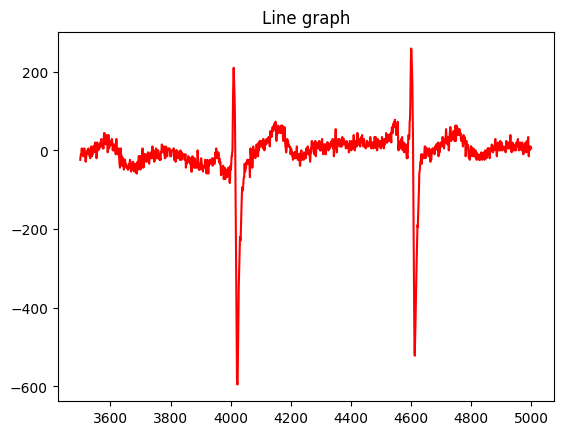

In [96]:
s = 3500
e = 5000
heart_signal = heart_data[4]

time = np.arange(s, e)
ee = ECGExtractor(heart_signal)
plt.title("Line graph")
plt.plot(time, heart_signal[s:e], color="red")


##Example##

In [97]:
ee = ECGExtractor(heart_signal)
print(s, e)
print(ee.point_extractor(s, e))

3500 5000
[{'peak_id': 6, 'P': 3952, 'Q': 3997, 'R': 4010, 'S': 4022, 'T': 4149}, {'peak_id': 7, 'P': nan, 'Q': 4593, 'R': 4600, 'S': 4612, 'T': nan}]
